# 12 The Heston Model and Forecasting Option Market Values

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In [3]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
sns.set_style('darkgrid')
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy.stats import rv_discrete
from statsmodels.stats.diagnostic import acorr_ljungbox


%run functions.py


### The $n$-step discrete Heston Model:

Let $0 = t_0<t_1<\cdots <t_n = t$, then the $n$-step discrete Heston model assumes for each $1\leq i\leq n$ the variance of the log-returns at time $t_i$ is modeled as

$$v_{t_i} = |v_{i-1} + \kappa(\theta - v_{t_{i-1}})(t_i-t_{i-1}) + \xi\sqrt{|v_{i-1}|(t_i-t_{i-1})}\mathcal{N}^{v}(0,1)|$$

and the distribution of stock paths from time $t_{i-1}$ to $t_i$ is modeled as

$$S_{t_i} = S_{t_{i-1}}e^{(\mu + r - .5v_{t_{i-1}})(t_i-t_{i-1}) + \sqrt{|v_{t_{i-1}}|(t_i-t_{i-1})}\mathcal{N}^S(0,1)}$$
where:

- $S_0$ is the initial stock price;
- $S_t$ is the stock price at time $t$;
- $v_0$ is the variance of the stock at time $0$;
- $v_t$ is the variance of the stock at time $t$;
- $\mu$ is the excess drift of the log-returns of the stock;
- $r$ is the risk-free interest rate;
- $\kappa$ is the **mean-reversion rate** of the variance process;
- $\theta$ is the **long-run variance level** of the variance process;
- $\xi$ is the **volatility of volatility**
- $\mathcal{N}^{v}(0,1)$ and $\mathcal{N}^{S}(0,1)$ are standard normal distributions with correlation $\rho$


### Remark 1:

The general definition of the Heston Model describes the variance and stock paths as being modeled as intertwined solutions to a system of stochastic Partial Differential Equations. The limiting distribution of variances and stock paths of the discrete models as the number of steps tends to $\infty$ is the continuous model described by the system of stochastic partial differential equations.

### Remark 2:

The Heston model is a generalization of the Black-Scholes/Geometric Brownian Motion Model. The two models agree if:
- $v_0 = \theta$
- $\kappa = 0$
- $\xi = 0$.

### Remark 3:

It is common practice to use $\mbox{max}(v_i,0)$ instead of $|v_i|$ in the Heston model.

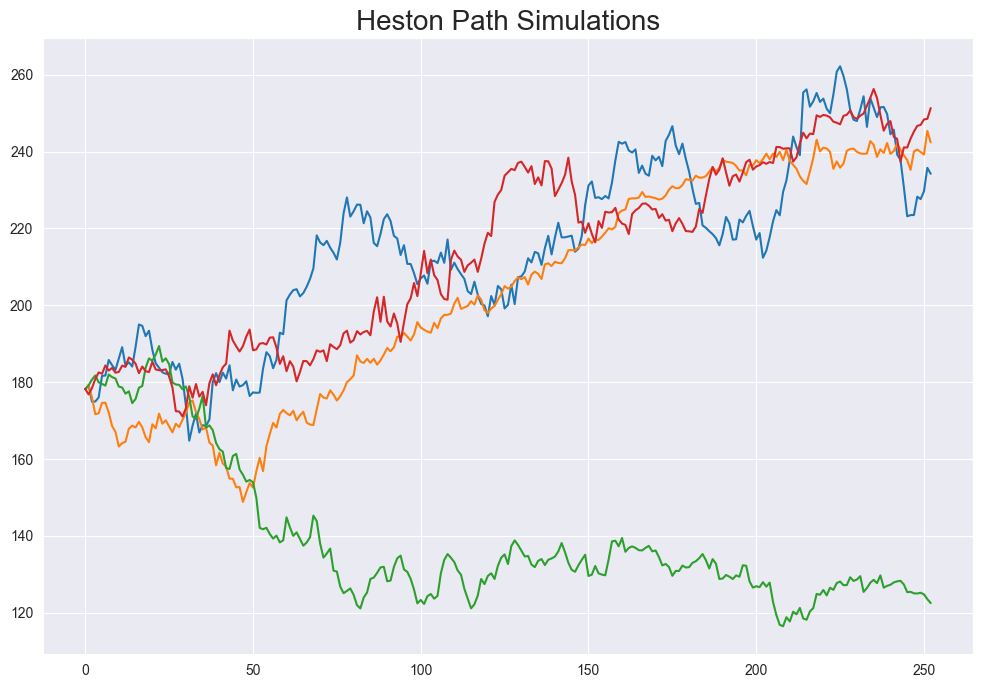

In [5]:
### Visual of stock paths measure simulated through the Heston model

kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 4 #Number of simulations

mu = .034 #Excess drift of log returns



heston_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

plt.figure(figsize = (12,8))
for path in heston_paths:
    plt.plot(path)
    
    
plt.title('Heston Path Simulations', size = 20)

plt.show()

In [10]:
help(heston_path_sim)

Help on function heston_path_sim in module __main__:

heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims=1, mu=0, return_vol=False)
    Simulation of stock path movements under the Heston stochastic volatility model.
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Total time horizon (in years)
    - n_steps (int): Number of time steps
    - kappa (float): Rate of mean reversion of variance
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility
    - rho (float): Correlation between Brownian motions
    - n_sims (int): Number of simulated paths
    - mu (float): Excess drift of log-returns
    - return_vol (bool): Whether to return the simulated variance paths
    
    Returns:
    - paths (ndarray): Simulated stock price paths of shape (n_sims, n_steps + 1)
    - vols (ndarray, optional): Simulated variance paths if return_vol is True



Monte-Carlo Simulated value of Call Option, Heston Model: $18.69 with standard error 0.079582.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


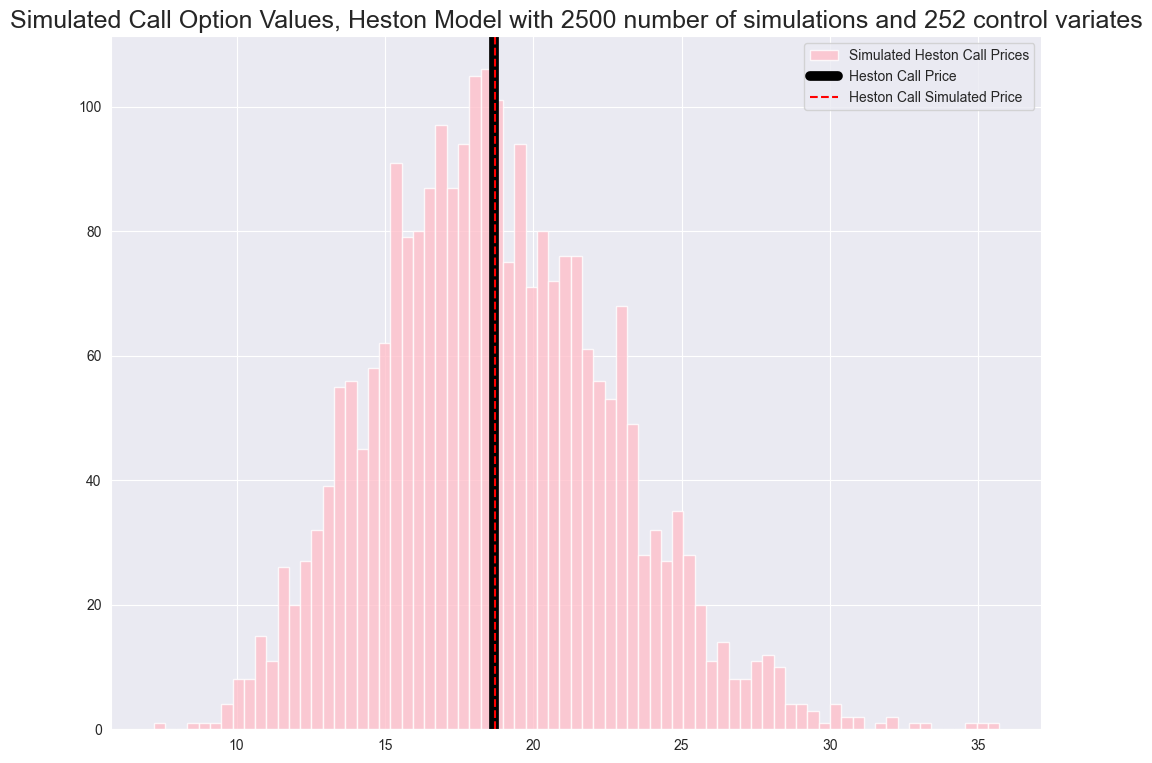

In [8]:
#Use Monte-Carlo methods to simulate price of call option under Heston-Model.
#Compare estimate provided by faster method of numeric integration.

### Visual of stock paths measure simulated through the Heston model


#Heston parameters
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 2500 #Number of simulations

mu = .034 #Excess drift of log returns


#Strike

K = 185



#Monte-Carlo Simulation
call_payouts_hedged = heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

heston_call_sim = np.mean(np.mean(call_payouts_hedged))

heston_std_err = np.std(call_payouts_hedged)/np.sqrt(n_sims)

heston_call_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)


print(f'Monte-Carlo Simulated value of Call Option, Heston Model: ${heston_call_sim:.2f}\
 with standard error {heston_std_err:.6f}.')


print('-----'*10)
print('-----'*10)


print(f'Actual value of call option under Heston model assumption: ${heston_call_price:.2f}.')


print('-----'*10)
print('-----'*10)


plt.figure(figsize = (12,9))

plt.hist(call_payouts_hedged, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Call Prices')
plt.axvline(heston_call_price, label = 'Heston Call Price',color = 'black', lw = '7', alpha = 1)
plt.axvline(heston_call_sim, label = 'Heston Call Simulated Price', color = 'red', ls = '--')



plt.title(f'Simulated Call Option Values, Heston Model with {n_sims} number of simulations and {n_steps} control variates', size = 18)



plt.legend()

plt.show()


Heston Monte-Carlo Simulated value of Call Option with 1 control variates and 2500 simulations: $16.06 with standard error 0.238009.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


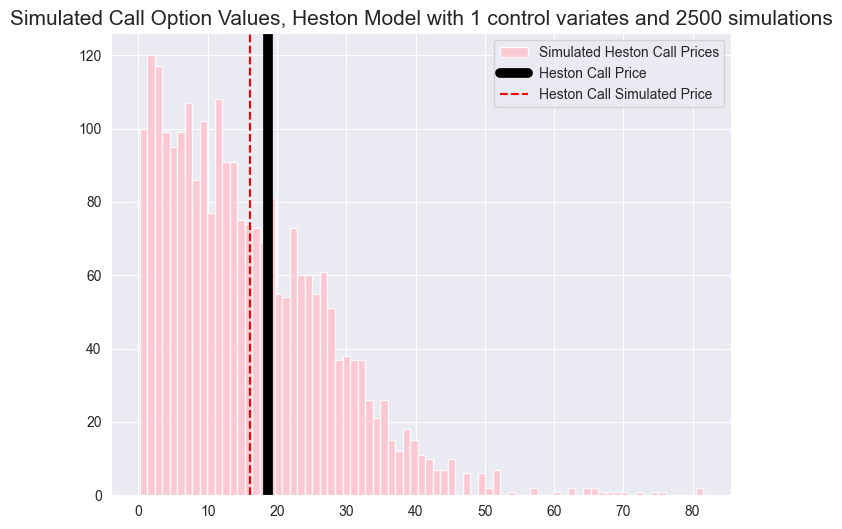

Heston Monte-Carlo Simulated value of Call Option with 2 control variates and 2500 simulations: $19.11 with standard error 0.247671.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


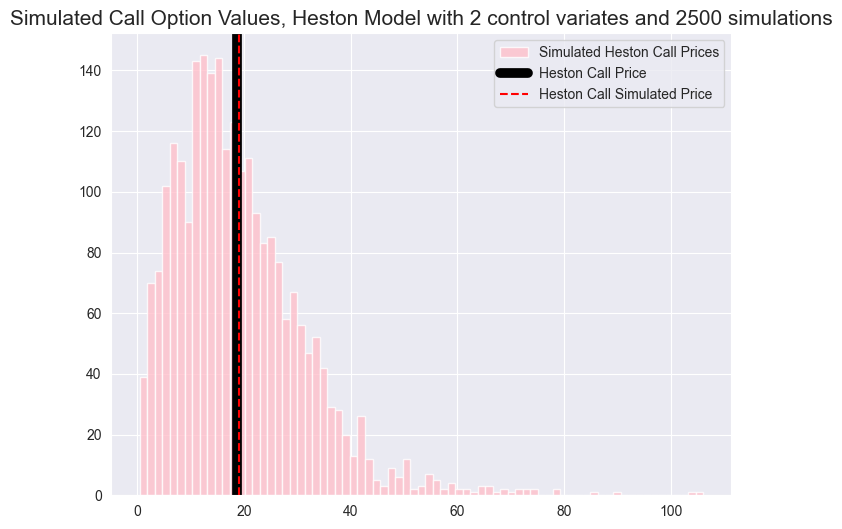

Heston Monte-Carlo Simulated value of Call Option with 3 control variates and 2500 simulations: $18.89 with standard error 0.201941.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


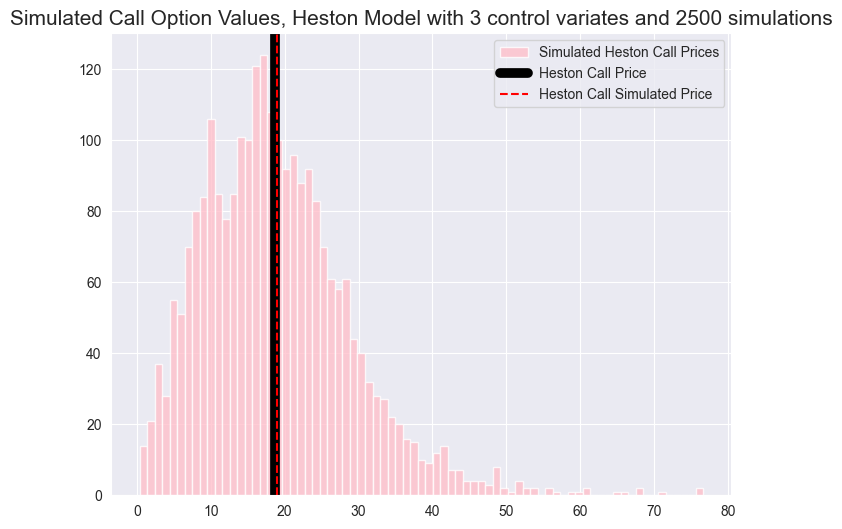

Heston Monte-Carlo Simulated value of Call Option with 5 control variates and 2500 simulations: $19.02 with standard error 0.173447.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


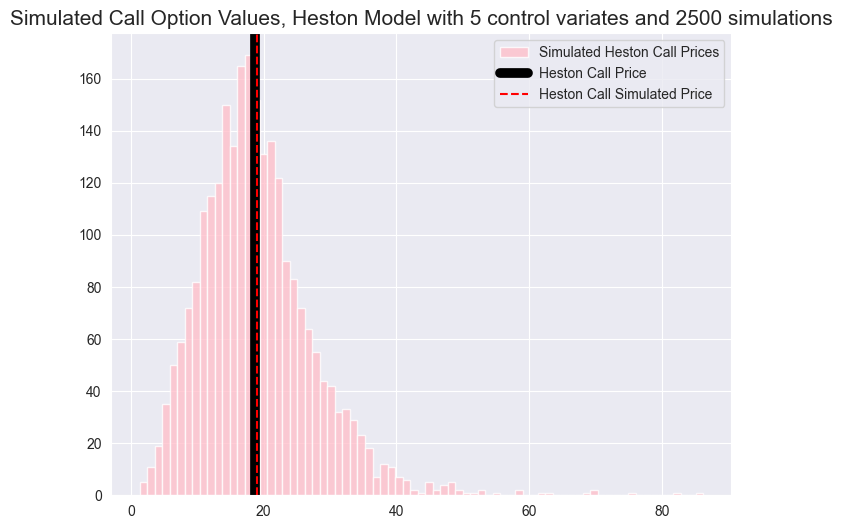

Heston Monte-Carlo Simulated value of Call Option with 10 control variates and 2500 simulations: $18.75 with standard error 0.130792.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


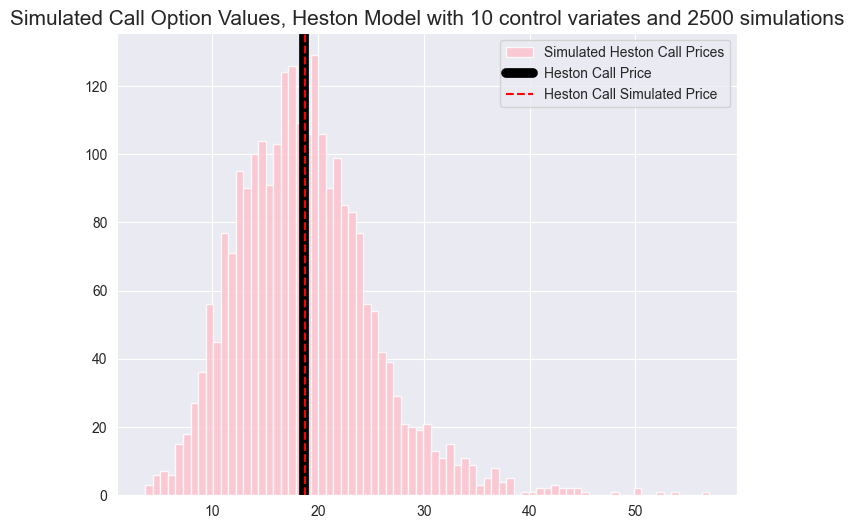

Heston Monte-Carlo Simulated value of Call Option with 50 control variates and 2500 simulations: $18.82 with standard error 0.091561.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


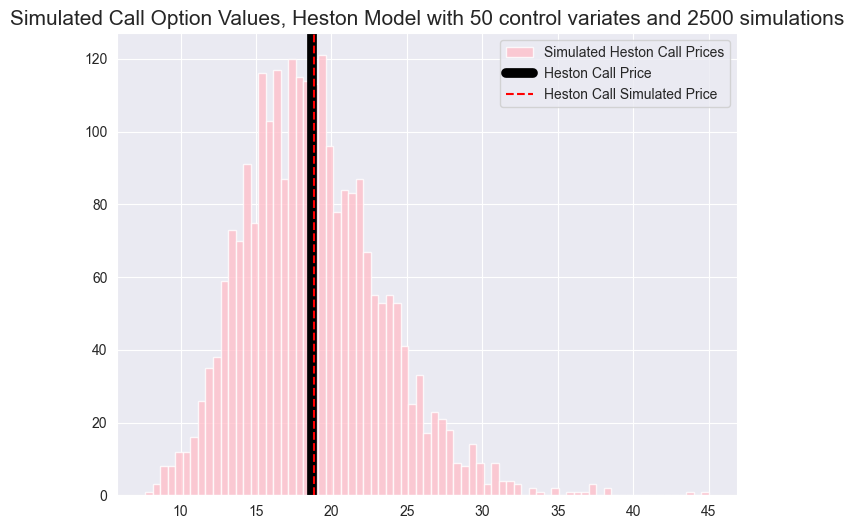

Heston Monte-Carlo Simulated value of Call Option with 252 control variates and 2500 simulations: $18.70 with standard error 0.077390.
--------------------------------------------------
--------------------------------------------------
Actual value of call option under Heston model assumption: $18.69.
--------------------------------------------------
--------------------------------------------------


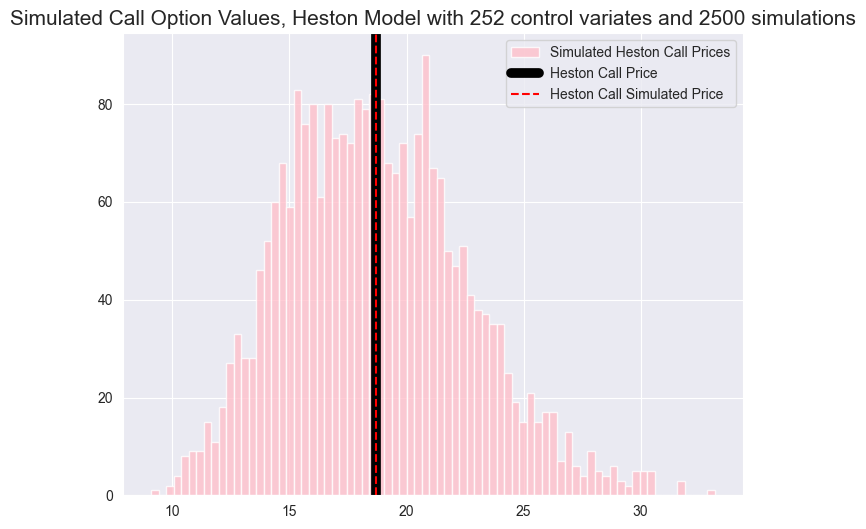

In [12]:
#Use Monte-Carlo methods to simulate price of call option under Heston-Model  
#with an increasing number of steps = delta-based control variates.
#Compare estimate provided by faster method of numeric integration.

#Heston parameters
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

r = .039 #Risk-free interest rate

n_sims = 2500 #Number of simulations

mu = .034 #Excess drift of log returns


#Strike

K = 185



steps = [1, 2, 3, 5, 10, 50, 252]

for n_steps in steps:


    #Monte-Carlo Simulation
    call_payouts_hedged = heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu=0)

    heston_call_sim = np.mean(np.mean(call_payouts_hedged))

    heston_std_err = np.std(call_payouts_hedged)/np.sqrt(n_sims)

    heston_call_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)


    print(f'Heston Monte-Carlo Simulated value of Call Option with {n_steps} control variates\
 and {n_sims} simulations: ${heston_call_sim:.2f} with standard error {heston_std_err:.6f}.')


    print('-----'*10)
    print('-----'*10)


    print(f'Actual value of call option under Heston model assumption: ${heston_call_price:.2f}.')


    print('-----'*10)
    print('-----'*10)


    plt.figure(figsize = (8,6))

    plt.hist(call_payouts_hedged, bins = 75, color = 'pink', alpha = .8, label = 'Simulated Heston Call Prices')
    plt.axvline(heston_call_price, label = 'Heston Call Price',color = 'black', lw = '7', alpha = 1)
    plt.axvline(heston_call_sim, label = 'Heston Call Simulated Price', color = 'red', ls = '--')



    plt.title(f'Simulated Call Option Values, Heston Model with {n_steps}\
 control variates and {n_sims} simulations', size = 15)



    plt.legend()

    plt.show()


In [13]:
### The Heston model agrees with the Black-Scholes model if kappa and xi are 0 and v0 = theta.

#Heston parameters
kappa = 0 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = 0 # Volatility of Volatility (Typical range .2 to 1)

v0 = .3**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 2500 #Number of simulations

mu = .034 #Excess drift of log returns


#Strike

K = 185


call_payouts_hedged = heston_call_MC(S0, K, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu=0)

heston_call_sim = np.mean(np.mean(call_payouts_hedged))

heston_std_err = np.std(call_payouts_hedged)/np.sqrt(n_sims)

black_scholes_price = bs_call(S0,K,np.sqrt(theta),t,r)


print(f'Monte-Carlo Simulated value of Call Option, Heston Model: ${heston_call_sim:.2f}\
 with standard error {heston_std_err:.6f}.')


print('-----'*10)
print('-----'*10)




print(f'Value of call option under Black-Scholes assumption: ${black_scholes_price:.2f}.')


Monte-Carlo Simulated value of Call Option, Heston Model: $21.36 with standard error 0.022960.
--------------------------------------------------
--------------------------------------------------
Value of call option under Black-Scholes assumption: $21.37.


In [14]:
### Methods of numeric integration allow for quick valuation of option values under Heston model

#Heston Parameters.

#Heston parameters
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

r = .039 #Risk-free interest rate

mu = .034 #Excess drift of log returns





ttes = [.01, .2, .5, .75, 1, 1.5]
strikes = range(160,201)


heston_prices = [[heston_call(S0, K, v0, r, t, kappa, theta, xi, rho) for K in strikes]for t in ttes]

price_matrix = pd.DataFrame(heston_prices, index = ttes, columns = strikes)
price_matrix.index.name = 'Time to Expiration (Years)'
price_matrix.columns.name = 'Strike Price'


price_matrix

Strike Price,160,161,162,163,164,165,166,167,168,169,...,191,192,193,194,195,196,197,198,199,200
Time to Expiration (Years),,,,,,,,,,,,,,,,,,,,,
0.01,18.259927,17.288780,16.307742,15.310145,14.295667,13.270257,12.243848,11.226878,10.227014,9.247313,...,-0.048039,-0.036433,-0.014731,0.011243,0.034610,0.049238,0.051325,0.040330,0.019054,-0.007147
0.20,21.079470,20.240412,19.413026,18.597929,17.795745,17.007105,16.232637,15.472971,14.728730,14.000528,...,2.915376,2.648093,2.399429,2.168759,1.955408,1.758666,1.577785,1.411990,1.260487,1.122467
0.50,26.060373,25.322524,24.594085,23.875265,23.166268,22.467293,21.778536,21.100188,20.432435,19.775455,...,8.306080,7.926064,7.558219,7.202447,6.858638,6.526668,6.206402,5.897692,5.600378,5.314289
0.75,29.719840,29.025418,28.339058,27.660872,26.990970,26.329457,25.676436,25.032007,24.396265,23.769302,...,12.323763,11.912924,11.511546,11.119585,10.736992,10.363710,9.999679,9.644830,9.299092,8.962386
1.00,33.030489,32.366657,31.709934,31.060389,30.418085,29.783085,29.155450,28.535236,27.922499,27.317290,...,15.974223,15.549429,15.132467,14.723307,14.321918,13.928263,13.542305,13.164002,12.793308,12.430175
1.50,38.887306,38.266886,37.652299,37.043572,36.440729,35.843795,35.252792,34.667741,34.088662,33.515574,...,22.441695,22.008009,21.580298,21.158541,20.742715,20.332798,19.928765,19.530589,19.138243,18.751698


### Historical Volatility Distributions

Historical volatilities of stock paths are more accurately captured by the Heston model over the Black-Scholes model.

Through hedging, the value of an option is a measurement of the behavior of volatility of the stock. Meaning that option values are neutral to stock drift with strategically implemented hedging strategies.

Therefore the Heston model has the potential to more accurately capture volatility behavior of a stock path and therefore provide more reliable measurements of an option contract's value.

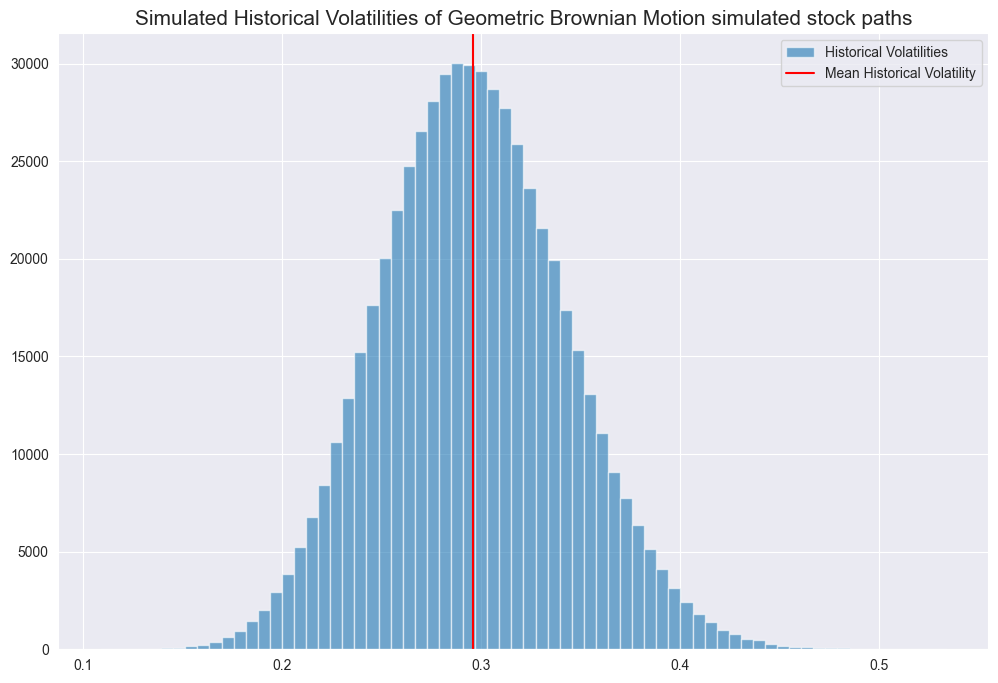

In [15]:
#Visual of simulated historical volatilities realized under Black-Scholes assumptions

### Simulated stock paths under Geometric Brownian Motion (Black-Scholes Model)
S0 = 178.2
sigma = .3
t = 1
r = .039
mu = .034
n_steps = 252
n_sims = 2500



paths = gbm_path_sim(S0, sigma, t, r, mu, n_sims, n_steps)

#Convert simulated paths to pandas series
paths = [pd.Series(path) for path in paths]


# Compute 21-day volatilities of paths
path_rolling_vols = [np.log(path/path.shift(1)).rolling(window=21).std()*np.sqrt(252) for path in paths]

#Concatenate the rolling volatilities of the simulated paths
all_rolling_vols = pd.concat(path_rolling_vols, ignore_index=True).dropna()

#Create Histogram of volatilities

plt.figure(figsize = (12,8))
plt.hist(all_rolling_vols, bins = 70, alpha = .6, label = 'Historical Volatilities')
plt.axvline(np.mean(all_rolling_vols), color = 'red', label = 'Mean Historical Volatility')
plt.legend()

plt.title('Simulated Historical Volatilities of Geometric Brownian Motion simulated stock paths', size = 15)

plt.show()

In [16]:
stock = yf.download('T', period = '15y', interval = '1d')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [19]:
np.log(stock['Close']/stock['Close'].shift(1)).rolling(window = 21).std()*np.sqrt(252)

Ticker,T
Date,
2010-06-21,NaN
2010-06-22,NaN
2010-06-23,NaN
2010-06-24,NaN
2010-06-25,NaN
...,...
2025-06-12,0.197728
2025-06-13,0.198465
2025-06-16,0.168803


[*********************100%***********************]  1 of 1 completed


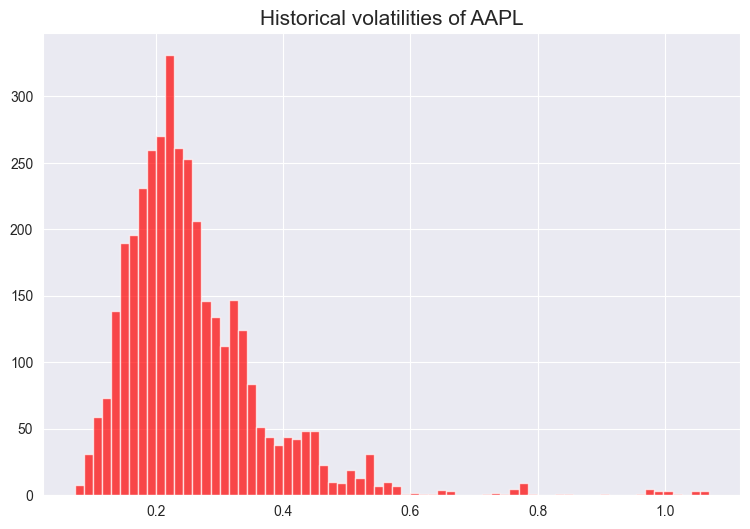

[*********************100%***********************]  1 of 1 completed


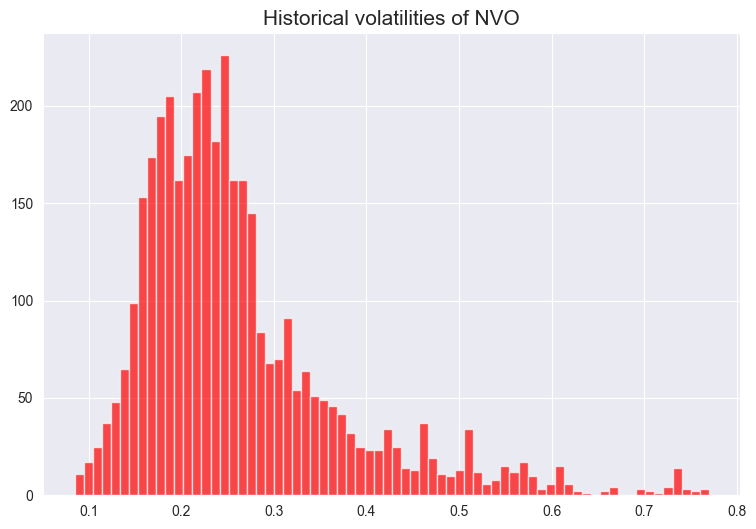

[*********************100%***********************]  1 of 1 completed


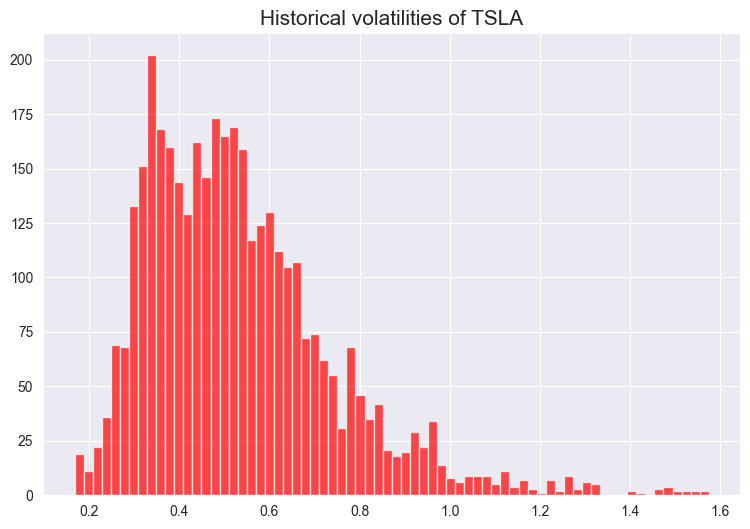

[*********************100%***********************]  1 of 1 completed


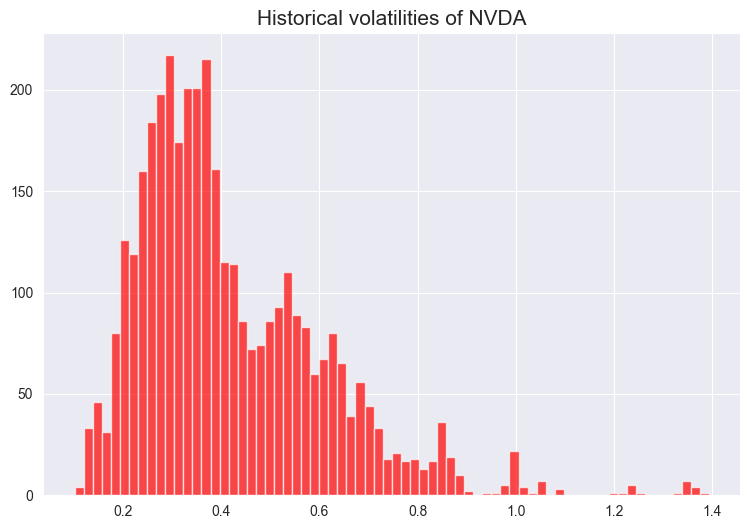

[*********************100%***********************]  1 of 1 completed


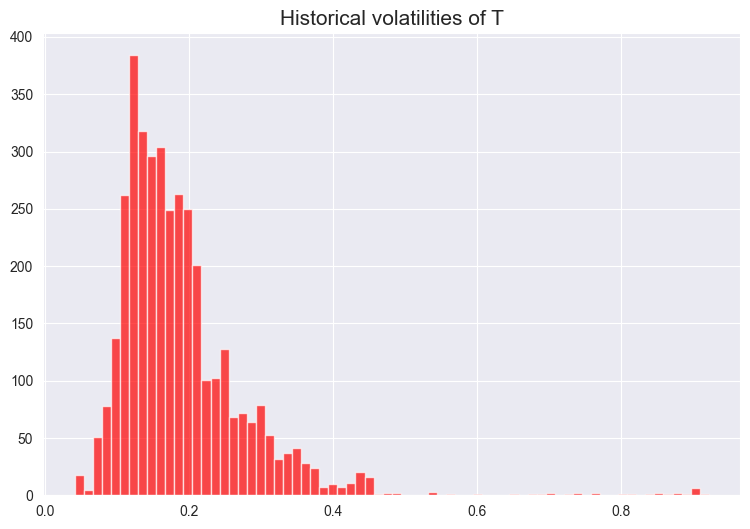

[*********************100%***********************]  1 of 1 completed


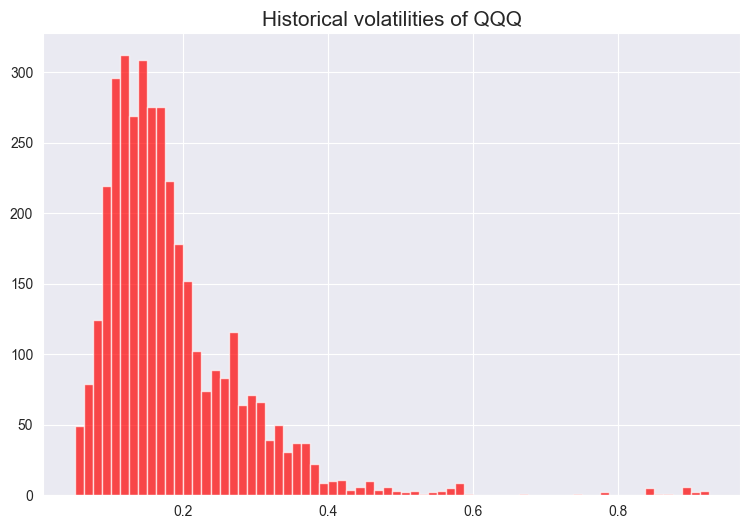

In [22]:
#Real World Distribution of Historical volatilites of a stock

tickers = ['AAPL', 'NVO', 'TSLA', 'NVDA', 'T', 'QQQ']

for ticker in tickers:

    stock = yf.download(ticker, period = '15y', interval = '1d')

    #Historical volatilities of stock measured over 21 day trading days
    historical_vols = np.log(stock['Close']/stock['Close'].shift(1)).rolling(window = 21).std()*np.sqrt(252)

    plt.figure(figsize = (9,6))
    plt.hist(historical_vols, bins = 70, color = 'red', alpha = .7)
    plt.title(f'Historical volatilities of {ticker}', size = 15)
    plt.show()

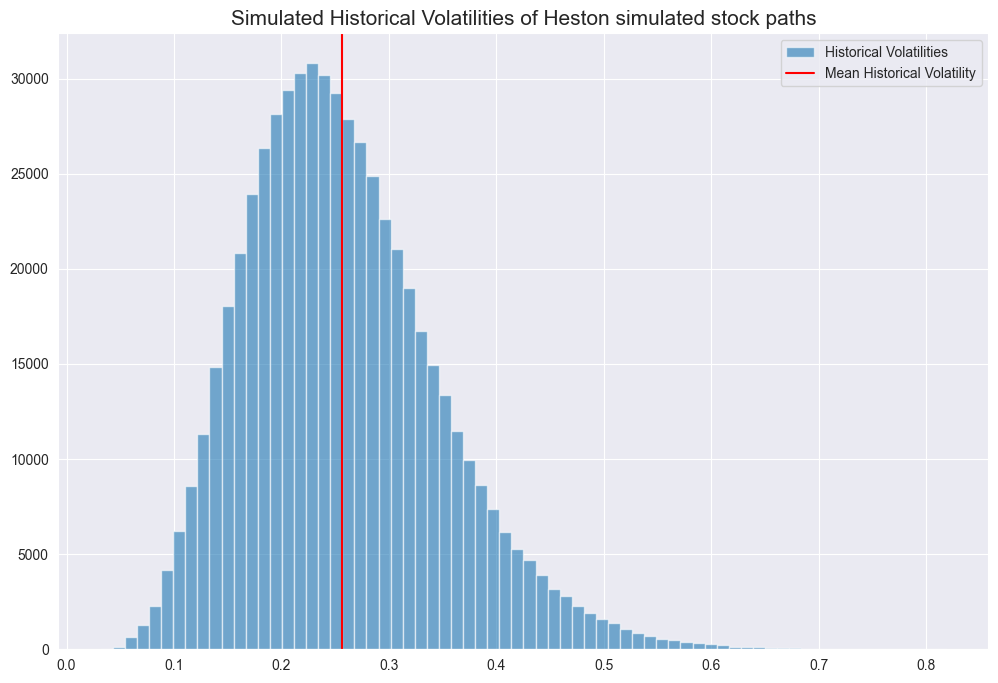

In [23]:
### Simulated Historical volatilites of stock path under Heston model.


#Heston parameters
kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 2500 #Number of simulations

mu = .034 #Excess drift of log returns


#Strike

K = 185



paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu, False)



#Convert simulated paths to pandas series
paths = [pd.Series(path) for path in paths]


# Compute 21-day volatilities of paths
path_rolling_vols = [np.log(path/path.shift(1)).rolling(window=21).std()*np.sqrt(252) for path in paths]

#Concatenate the rolling volatilities of the simulated paths
all_rolling_vols = pd.concat(path_rolling_vols, ignore_index=True).dropna()

#Create Histogram of volatilities

plt.figure(figsize = (12,8))
plt.hist(all_rolling_vols, bins = 70, alpha = .6, label = 'Historical Volatilities')
plt.axvline(np.mean(all_rolling_vols), color = 'red', label = 'Mean Historical Volatility')

plt.title('Simulated Historical Volatilities of Heston simulated stock paths', size = 15)

plt.legend()

plt.show()

### Question

Can the distribution of historical volatilites be used to create a discrete distribution that successefully models the call value of the Heston model?


If the answer is yes, then simulation of the Heston model can be dramatically sped up.


Below we simulate that a discrete distribution does not capture the Heston model.

In [25]:
#From a discrete distribution of volatilities from simulated historical volatilities under Heston model
counts, bin_edges = np.histogram(all_rolling_vols, bins=50)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
probabilities = counts / counts.sum()
discrete_dist = rv_discrete(name='hist_based', values=(bin_midpoints, probabilities))



dt = t/n_steps

# Simulate volatility paths
noise = discrete_dist.rvs(size=(n_sims, n_steps))
log_returns = (r - 0.5 * noise**2) * dt + noise * np.sqrt(dt)
log_price_paths = np.cumsum(log_returns, axis=1)
paths = S0 * np.exp(log_price_paths)
paths = np.hstack([S0 * np.ones((n_sims, 1)), paths])

# Delta hedging
deltas = np.array([
    bs_call_delta(paths[:, i], K, noise[:, i], t - i * dt, r)
    for i in range(n_steps)
]).T

stock_profits_steps = (paths[:, 1:]-np.exp(r * dt)*paths[:, :-1])*deltas*np.exp(-r*np.arange(1,n_steps+1)*dt)

stock_profits = np.sum(stock_profits_steps, axis=1)

# Payoffs
call_payoffs = np.maximum(paths[:, -1] - K, 0) * np.exp(-r * t)
sim_call_values = call_payoffs - stock_profits

# Output
sim_call_value = np.mean(sim_call_values)
std_err = np.std(sim_call_values) / np.sqrt(n_sims)
heston_call_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)

print(f'Simulated call value from discrete distribution: ${sim_call_value:.2f} with standard error {std_err:.6f}')
print('--------' * 10)
print('--------' * 10)
print(f'Heston value of call option: ${heston_call_price:.2f}.')
print('--------' * 10)
print('--------' * 10)
print(f'Discrete distributions do not capture autoregressive influence of variance found of the Heston model.')

Simulated call value from discrete distribution: $20.27 with standard error 0.022249
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston value of call option: $18.69.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Discrete distributions do not capture autoregressive influence of variance found of the Heston model.


In [26]:
#Statistical test if there is autoregressive behavior in historical volatilities
tickers = ['AAPL', 'NVO', 'TSLA', 'NVDA', 'T', 'QQQ']
for ticker in tickers:
    stock = yf.download(ticker, period = '15y', interval = '1d')
    #Historical volatilities of stock measured over 21 day trading days
    historical_vols = np.log(stock['Close']/stock['Close'].shift(1)).rolling(window = 21).std()*np.sqrt(252)
    data = np.asarray(historical_vols.dropna())
    ljung_result = acorr_ljungbox(data, lags=[10], return_df=True)
    p_value = ljung_result['lb_pvalue'].iloc[0]
    if p_value < 0.05:
        print(f'p-value: {p_value} - Reject null hypothesis: statistical evidence of autoregressive \
behavior in historical volatility of {ticker}.')
        print('--------'*10)
        print('--------'*10)
    else:
        print(f'p-value: {p_value} - Not statistically significant to reject null hypothesis: \
no clear autoregressive behavior in historical volatility of {ticker}.')
        print('--------'*10)
        print('--------'*10)

[*********************100%***********************]  1 of 1 completed


p-value: 0.0 - Reject null hypothesis: statistical evidence of autoregressive behavior in historical volatility of AAPL.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


p-value: 0.0 - Reject null hypothesis: statistical evidence of autoregressive behavior in historical volatility of NVO.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


p-value: 0.0 - Reject null hypothesis: statistical evidence of autoregressive behavior in historical volatility of TSLA.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


p-value: 0.0 - Reject null hypothesis: statistical evidence of autoregressive behavior in historical volatility of NVDA.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


p-value: 0.0 - Reject null hypothesis: statistical evidence of autoregressive behavior in historical volatility of T.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

p-value: 0.0 - Reject null hypothesis: statistical evidence of autoregressive behavior in historical volatility of QQQ.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


### Heston Calibration using Option Data

Standard methods of minimizing errors measured in terms of sums of least squares of the implied volatilities of option market price data is a standard method of estimating parameters of Heston model to forecast future distribution of option prices on the market.

In [28]:
ticker.options

('2025-06-20',
 '2025-06-27',
 '2025-07-03',
 '2025-07-11',
 '2025-07-18',
 '2025-07-25',
 '2025-08-01',
 '2025-08-15',
 '2025-09-19',
 '2025-10-17',
 '2025-11-21',
 '2025-12-19',
 '2026-01-16',
 '2026-02-20',
 '2026-03-20',
 '2026-06-18',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17',
 '2027-12-17')

In [27]:
##yfinance does provide enough option data to play around with Heston calibration
stock_symbol = 'AAPL'
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')



expirations = ticker.options
# Store results
option_data = []

for date in expirations:
    chain = ticker.option_chain(date)

    # Add expiration and label
    calls = chain.calls.copy()
    calls['expiration'] = date
    calls['option_type'] = 'call'

    puts = chain.puts.copy()
    puts['expiration'] = date
    puts['option_type'] = 'put'

    option_data.append(calls)
    option_data.append(puts)

# Combine all into one DataFrame
options_data = pd.concat(option_data, ignore_index=True)

[*********************100%***********************]  1 of 1 completed


In [29]:
options_data

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration,option_type
0,AAPL250620C00005000,2025-06-18 15:13:32+00:00,5.0,190.50,190.95,192.60,-1.000000,-0.522193,12.0,828,22.562503,True,REGULAR,USD,2025-06-20,call
1,AAPL250620C00010000,2025-06-18 15:13:32+00:00,10.0,186.54,186.10,187.20,-6.100006,-3.166531,10.0,51,15.625000,True,REGULAR,USD,2025-06-20,call
2,AAPL250620C00015000,2025-06-16 13:43:24+00:00,15.0,181.59,180.90,182.65,-0.339996,-0.186883,5.0,3,15.109376,True,REGULAR,USD,2025-06-20,call
3,AAPL250620C00020000,2025-06-18 18:11:51+00:00,20.0,176.17,175.95,177.60,-6.830002,-3.732241,5.0,6,13.328127,True,REGULAR,USD,2025-06-20,call
4,AAPL250620C00025000,2025-06-13 18:58:54+00:00,25.0,171.33,170.90,172.65,0.000000,0.000000,4.0,2,11.984378,True,REGULAR,USD,2025-06-20,call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,AAPL271217P00350000,2025-06-02 13:49:16+00:00,350.0,148.64,151.00,155.80,0.000000,0.000000,2.0,0,0.234322,True,REGULAR,USD,2027-12-17,put
2171,AAPL271217P00370000,2025-04-15 16:23:18+00:00,370.0,166.14,0.00,0.00,0.000000,0.000000,NaN,0,0.000010,True,REGULAR,USD,2027-12-17,put
2172,AAPL271217P00400000,2025-05-22 18:39:16+00:00,400.0,196.88,201.00,206.00,0.000000,0.000000,2.0,0,0.277412,True,REGULAR,USD,2027-12-17,put
2173,AAPL271217P00435000,2025-05-14 14:15:57+00:00,435.0,221.93,236.50,241.50,0.000000,0.000000,NaN,0,0.311774,True,REGULAR,USD,2027-12-17,put


In [30]:
##Functions for option data obtained through y-finance

from dateutil import parser
from dateutil.tz import tzutc

def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Finds approximate spot price at the time of last trade.
    The spot price is approximate since yfinance does not provide 1-second data, only minute-by-minute.

    Parameters:
    stock_data (pd.Series or pd.DataFrame): stock prices with DatetimeIndex
    last_trade_date (pd.Timestamp): timestamp of last trade of option contract

    Returns:
    float: approximate spot price, or NaN if unavailable
    """
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')


In [31]:
stock_symbol = 'AAPL'
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')



expirations = ticker.options


#Create array to store options data
option_data = []

for date in expirations:
    chain = ticker.option_chain(date)

    # Add expiration and label
    calls = chain.calls.copy()
    calls['expiration'] = date
    calls['option_type'] = 'call'

    puts = chain.puts.copy()
    puts['expiration'] = date
    puts['option_type'] = 'put'

    option_data.append(calls)
    option_data.append(puts)

# Combine all into one DataFrame and delete implied volatility column since we'll recalculate.
options_data = pd.concat(option_data, ignore_index=True)
options_data = options_data.drop(columns=['impliedVolatility'])


#Delete any options that were traded in the interval of historical stock values obtained
start_date = stock_data.index[0]
options_data = options_data[options_data['lastTradeDate']>=start_date]


#Insert column of time to expiration in years of the option contract measured from time of last trade
options_data['time_to_expiration'] = options_data.apply(
lambda row: find_tte_yf_options(expiration_date = row['expiration'],
                               last_trade_date = row['lastTradeDate']),
    axis = 1
)


#Add in column of the spot price of stock when the option trade occured.
options_data['spot_price'] = options_data.apply(
    lambda row: yf_find_approx_spot(stock_data['Close'], row['lastTradeDate']),
    axis=1
)
options_data = options_data.dropna()





#Create data frames that keeps relevant information and separate calls from puts.
options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',\
                             'expiration', 'option_type','time_to_expiration', 'spot_price']]
options_data_calls = options_data[(options_data['option_type'] == 'call')].copy()
options_data_puts = options_data[(options_data['option_type'] == 'put')].copy()



#Add implied volatility column in calls data frame 
r = 0.039
options_data_calls['implied_volatility'] = options_data_calls.apply(
    lambda row: implied_volatility_call(
        market_price=row['lastPrice'],
        S0 = row['spot_price'],
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)


#Add implied volatility column in puts data frame 
options_data_puts['implied_volatility'] = options_data_puts.apply(
    lambda row: implied_volatility_put(
        market_price=row['lastPrice'],
        S0 = row['spot_price'],
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)

#Remove rows with undefined values
options_data_calls = options_data_calls.dropna()
options_data_puts = options_data_puts.dropna()

[*********************100%***********************]  1 of 1 completed


In [34]:
##Examine call options data
options_data_calls

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
1052,120.0,79.50,2025-06-18 17:31:27+00:00,2025-12-19,call,0.504563,196.070007,0.447235
1058,150.0,51.75,2025-06-18 16:58:48+00:00,2025-12-19,call,0.504626,196.529999,0.340212
1060,160.0,43.00,2025-06-18 18:57:09+00:00,2025-12-19,call,0.504400,195.369995,0.350683
1061,165.0,40.45,2025-06-18 15:02:56+00:00,2025-12-19,call,0.504846,197.185104,0.341546
1063,175.0,32.20,2025-06-18 19:37:03+00:00,2025-12-19,call,0.504324,196.220001,0.330312
...,...,...,...,...,...,...,...,...
1408,310.0,0.77,2025-06-18 18:44:46+00:00,2026-03-20,call,0.753739,196.320908,0.270457
1409,320.0,0.60,2025-06-18 19:01:50+00:00,2026-03-20,call,0.753707,195.259598,0.277074
1412,350.0,0.32,2025-06-18 16:50:40+00:00,2026-03-20,call,0.753956,196.940002,0.286678
1413,360.0,0.25,2025-06-18 13:52:12+00:00,2026-03-20,call,0.754296,196.389999,0.290343


In [33]:
## Remove additional rows if needed
options_data_calls = options_data_calls[(options_data_calls['time_to_expiration']<=1)\
                                        & (options_data_calls['time_to_expiration']>=.5)]

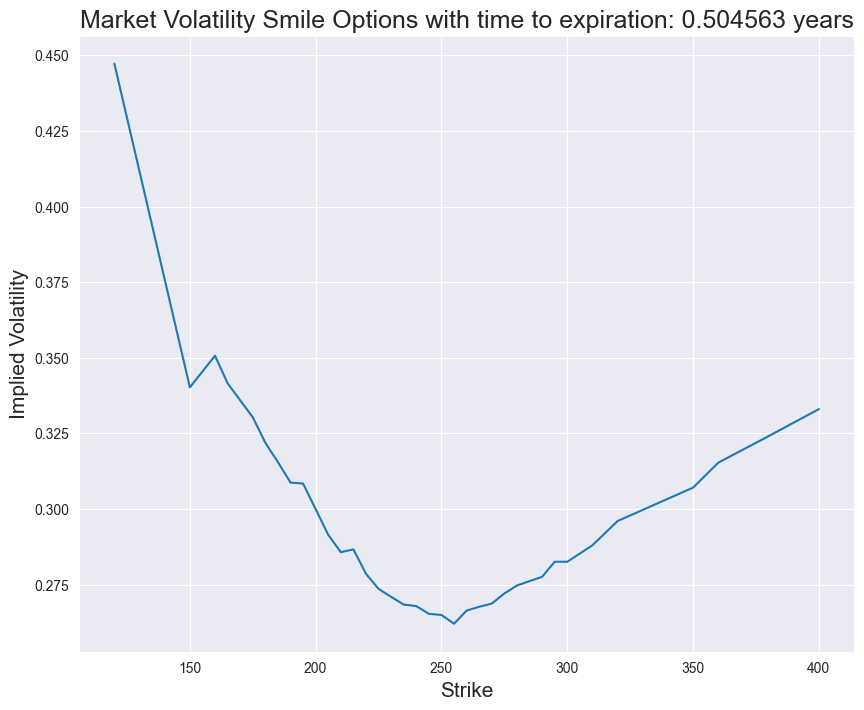

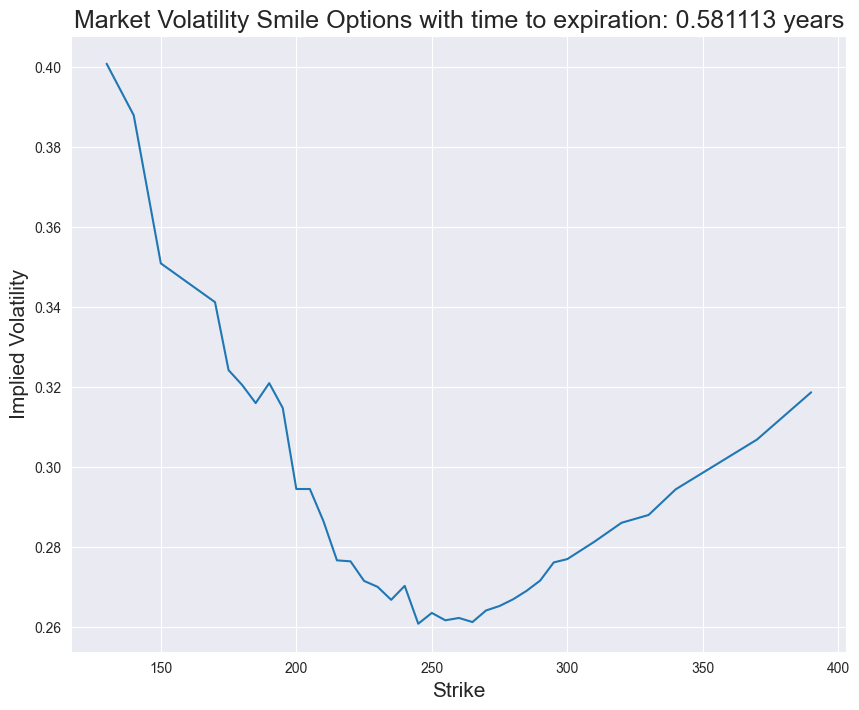

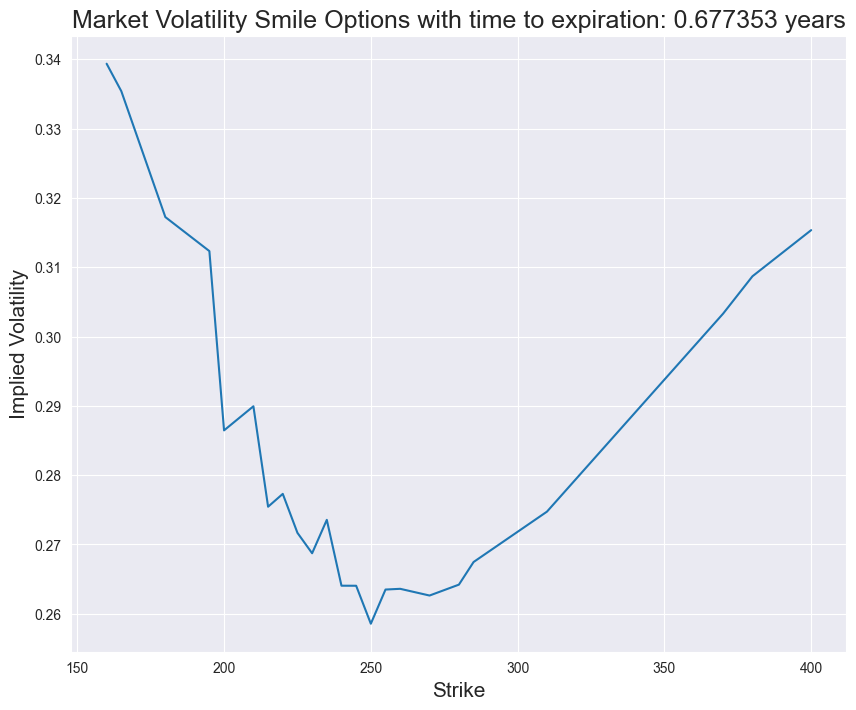

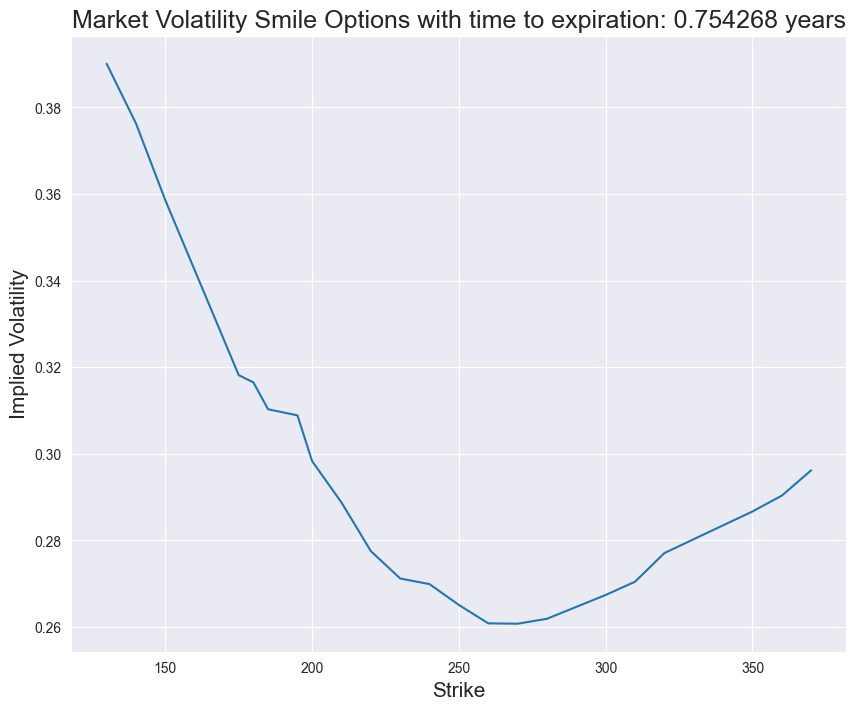

In [35]:
#Visual of volatility smiles from option data

for date in np.unique(options_data_calls['expiration'].values):
    options_with_same_expiration =  options_data_calls[options_data_calls['expiration']==date].copy()
    tte = options_with_same_expiration['time_to_expiration'].iloc[0]
    plt.figure(figsize = (10,8))
    plt.plot(options_with_same_expiration['strike'], options_with_same_expiration['implied_volatility'])

    plt.title(f'Market Volatility Smile Options with time to expiration: {tte:4f} years', size = 18)

    plt.ylabel('Implied Volatility', size = 15)
    plt.xlabel('Strike', size = 15)


    plt.show()

In [70]:
###Calibrate Heston model to option data using gradient descent.

def objective(params, option_data, r):
    kappa, theta, xi, rho, v0 = params
    
    error = 0
    for _, row in option_data.iterrows():
        model_price = heston_call(
            S0=row['spot_price'],
            K=row['strike'],
            v0=v0,
            r=r,
            t=row['time_to_expiration'],
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho
        )
        market_price = row['lastPrice']
        error += (model_price - market_price) ** 2
        
    return error / len(option_data)


initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 


r = 0.039  

result = minimize(
    objective,
    initial_guess,
    args=(options_data_calls, r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)


calibrated_params = result.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46078D+01    |proj g|=  1.49000D+00

At iterate    1    f=  6.75474D-01    |proj g|=  1.71798D+00

At iterate    2    f=  3.81332D-01    |proj g|=  1.71569D+00

At iterate    3    f=  3.63484D-01    |proj g|=  1.40170D+00

At iterate    4    f=  2.62598D-01    |proj g|=  9.34030D-01

At iterate    5    f=  1.71823D-01    |proj g|=  9.99900D-01

At iterate    6    f=  1.13405D-01    |proj g|=  9.53826D-01

At iterate    7    f=  1.05172D-01    |proj g|=  5.38026D-01

At iterate    8    f=  8.69348D-02    |proj g|=  5.43376D-01

At iterate    9    f=  7.69121D-02    |proj g|=  4.30099D-01

At iterate   10    f=  6.63560D-02    |proj g|=  9.04390D-01

At iterate   11    f=  6.43909D-02    |proj g|=  9.06512D-01

At iterate   12    f=  6.07582D-02    |proj g|=  9.08333D-01

At iterate   13    f=  5.3

In [100]:
print(f"Calibrated Heston parameters: \
kappa = {calibrated_params[0]}, \
theta = {calibrated_params[1]}, \
xi={calibrated_params[2]}, \
rho = {calibrated_params[3]}, \
v0 = {calibrated_params[4]}")

Calibrated Heston parameters: kappa = 0.9190587197661122, theta = 0.1191783099758894, xi=0.6289882184633288, rho = -0.5244275488071994, v0 = 0.09877369901685458


In [113]:
###Compare the calibrated long-run volatility and initial volatility with the one year and two day volatilities
### of AAPL stock.


#Volatility of AAPL over 1 year
aapl_stock_long_term = yf.download('AAPL', period = '1y', interval = '1d')


aapl_one_year_vol = (np.log(aapl_stock_long_term['Close']/\
                            aapl_stock_long_term['Close'].shift(1)).std()*np.sqrt(252)).iloc[0]

#Volatility of AAPL over 2 days
aapl_stock_short_term = yf.download('AAPL', period = '2d', interval = '1m')

aapl_two_day_vol = (np.log(aapl_stock_short_term['Close']/\
                           aapl_stock_short_term['Close'].shift(1)).std()*np.sqrt(252*60*24)).iloc[0]



print(f'Long run volatility of AAPL in Heston calibration is {np.sqrt(theta)}.')

print('-----'*10)

print(f'The volatility of AAPL over one year: {aapl_one_year_vol}.')

print('-----'*10)
print('-----'*10)

print(f'Initial volatility of AAPL in Heston Calibration is {np.sqrt(v0)}.')

print('-----'*10)

print(f'Volatility of AAPL over last two trading days is {aapl_two_day_vol}.')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Long run volatility of AAPL in Heston calibration is 0.3452221168695444.
--------------------------------------------------
The volatility of AAPL over one year: 0.320269073259163.
--------------------------------------------------
--------------------------------------------------
Initial volatility of AAPL in Heston Calibration is 0.3142828328382805.
--------------------------------------------------
Volatility of AAPL over last two trading days is 0.33282144131129554.


### Quicker calibration techniques

The above calibrates all parameters of the Heston model. 

The process can be quickened if you have specific values for some of the parameters. For example, initial variance $v_0$ and long-run variance $\theta$ can be obtained via measurements of historical data.

The process can also be accelerated by relaxing the numerical integration accuracy in the heston call function.

In [42]:
options_data_calls[options_data_calls['strike']==200]

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
1068,200.0,16.95,2025-06-18 19:55:24+00:00,2025-12-19,call,0.504290,196.690002,0.299917
1201,200.0,18.10,2025-06-18 19:58:18+00:00,2026-01-16,call,0.580996,196.669998,0.294407
1317,200.0,19.00,2025-06-18 18:08:56+00:00,2026-02-20,call,0.677095,196.099899,0.286461
1397,200.0,21.15,2025-06-18 19:59:39+00:00,2026-03-20,call,0.753597,196.250000,0.298300


In [43]:
100/252

0.3968253968253968

In [39]:
S0

196.25

In [38]:
S0 = stock_data['Close'].iloc[-1].iloc[0]

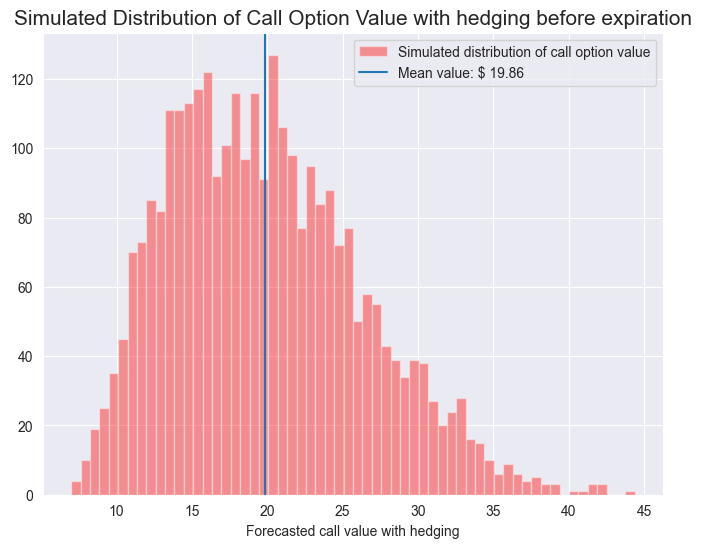

In [84]:
#Create a distribution of the value of 
#hedging a call option to a future date that is before the expiration of the call.


# Simulation
S0 = stock_data['Close'].iloc[-1].iloc[0]
kappa, theta, xi, rho, v0 = calibrated_params
K = options_data_calls['strike'].loc[1317]
tte = options_data_calls['time_to_expiration'].loc[1317]

n_steps = 100*2
n_sims = 3000
t = 100 / 252

paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, 0, return_vol=True)

# Delta computation via Black-Scholes
dt = t / n_steps
deltas = np.array([
    bs_call_delta(paths[:, i], K, np.sqrt(np.maximum(vols[:, i], 1e-10)), tte - i * dt, r)
    for i in range(n_steps)
]).T

# Stock hedging P&L
stock_profits_steps=(paths[:,1:]-np.exp(r*dt)*paths[:,:-1])*deltas*np.exp(-r*np.arange(1,n_steps+1)*dt)
stock_profits = np.sum(stock_profits_steps, axis=1)

# Heston call value at horizon
future_tte = tte - t
terminal_prices = paths[:, -1]
terminal_vols = vols[:, -1]

call_prices = Parallel(n_jobs=-1)(
    delayed(heston_call)(S, K, v, r, future_tte, kappa, theta, xi, rho)
    for S, v in zip(terminal_prices, terminal_vols)
)

simulated_call_market_value = np.exp(-r*t)*np.array(call_prices)-stock_profits

avg_value = np.mean(simulated_call_market_value)

# Plot
plt.figure(figsize=(8, 6))
plt.hist(simulated_call_market_value, bins=60, color = 'red', alpha = .4, label='Simulated distribution of call option value')
plt.title('Simulated Distribution of Call Option Value with hedging before expiration', size=15)
plt.xlabel('Forecasted call value with hedging')
plt.axvline(avg_value, label = f'Mean value: ${avg_value: .2f}')
plt.legend()
plt.show()